In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

## Auditd to transactions

In [4]:
# Helper functions
import re
type_lookup_table = {u'ADD_GROUP': 4,
 u'ADD_USER': 12,
 u'ANOM_ABEND': 0,
 u'CONFIG_CHANGE': 24,
 u'CRED_ACQ': 20,
 u'CRED_DISP': 13,
 u'CRED_REFR': 17,
 u'CRYPTO_KEY_USER': 6,
 u'CRYPTO_SESSION': 14,
 u'DAEMON_END': 8,
 u'DAEMON_START': 7,
 u'LOGIN': 19,
 u'NETFILTER_CFG': 22,
 u'SYSCALL': 5,
 u'SYSTEM_RUNLEVEL': 1,
 u'SYSTEM_SHUTDOWN': 18,
 u'USER_ACCT': 9,
 u'USER_AUTH': 10,
 u'USER_CHAUTHTOK': 21,
 u'USER_CMD': 3,
 u'USER_END': 23,
 u'USER_ERR': 11,
 u'USER_LOGIN': 2,
 u'USER_LOGOUT': 15,
 u'USER_START': 16}
def get_data(line, window_size=10, start_time=1422496861):
    timestamp = float(re.search('audit\(([0-9]+.[0-9]+)', line).group(1))
    type_code = type_lookup_table[re.search('type=([A-Z_]+) ', line).group(1)]
    window = int((timestamp -start_time)/window_size)
    return (window, type_code)
from collections import defaultdict
def get_longest_sets_possible(input_sets):
    def is_subset(main_set, item):
        is_subset = False
        for main_item in main_set:
            if item.issubset(main_item):
                is_subset = True
        return is_subset
    input_dict = defaultdict(set)
    for i in input_sets:
        input_dict[len(i)].add(i)
    
    output_sets = set()
    lengths = sorted(input_dict.keys(), reverse=True) # Largest first
    for i in input_dict[lengths[0]]: # since they are all the longest length we know that they are good
        output_sets.add(i) 
    
    for length in lengths[1:]:
        for item in input_dict[length]:
            if not is_subset(output_sets, item):
                output_sets.add(item)
    return output_sets

In [5]:
# Load Data
logs = sc.textFile("hdfs:///user/ytesfaye/lab41_logs_small.log.gz").repartition(10)
transactions = logs.map(get_data) \
                   .groupByKey() \
                   .map(lambda (key, iterator): list(set(iterator)))

In [22]:
raw_logs = sc.textFile('/magichour/tbird.log.preProc.gz').repartition(20)

In [ ]:
raw_logs_local = raw_logs.collect(20)

#tBird Logs

In [1]:
# Load Data
tbird_logs = sc.textFile("hdfs://l41-srv-mcdh01.b.internal/user/ytesfaye/tbird.log.out.logCluster.processed.gz").repartition(10)
def get_tbird_data(line, window_size=10, start_time=1131523501):
    ls = line.split(',')
    timestamp = float(ls[0])
    type_code = int(ls[1])
    window = int((timestamp -start_time)/window_size)
    return (window, type_code)
transactions = tbird_logs.map(get_tbird_data) \
                   .groupByKey() \
                   .map(lambda (key, iterator): list(set(iterator)))

# Load lookup table so that we can get back to raw strings
template_lookup = {}
for line in sc.textFile("hdfs://l41-srv-mcdh01.b.internal/user/ytesfaye/tmp.txt").collect():
    ls = line.split(',', 2)
    template_lookup[int(ls[0])] = ls[1]
dimension = max(template_lookup.keys()) + 1

# ML Lib LDA

In [2]:
from pyspark.mllib.linalg import Vectors, SparseVector
import numpy as np
from scipy.sparse import lil_matrix 
def make_vector(input_list, dimension=dimension):
    input_list, key = input_list
    return [key, SparseVector(dimension, sorted(input_list), np.ones(len(input_list)))]

In [3]:
vectorized_transactions = transactions.filter(lambda x: len(x) >= 2).zipWithUniqueId().map(make_vector)

In [10]:
from pyspark.mllib.clustering import LDA
model = LDA.train(vectorized_transactions, k=20, seed=1)

In [11]:
topics = model.topicsMatrix()

In [12]:
max_topics = 20
num_words_per_topic = 5
for topic_num, (ids, weights) in enumerate(model.describeTopics(num_words_per_topic)):
    print 'Topic %d'%topic_num
    print '---------------------'
    for i, n in enumerate(ids):
        print '%4d (%2.2f): %s'%(n, weights[i]*100.0, template_lookup[n])

Topic 0
---------------------
 241 (4.02): tbird-admin INT FILEPATH data_thread got not answer from any thunderbird_a INT datasource
 243 (3.91): tbird-admin INT FILEPATH data_thread got not answer from any thunderbird_d INT datasource
 242 (3.88): tbird-admin INT FILEPATH data_thread got not answer from any thunderbird_c INT datasource
 244 (3.86): tbird-admin INT FILEPATH data_thread got not answer from any thunderbird_b INT datasource
1110 (2.96): dn INT ntpd INT synchronized to IPADDR stratum INT
Topic 1
---------------------
 241 (8.02): tbird-admin INT FILEPATH data_thread got not answer from any thunderbird_a INT datasource
 242 (7.78): tbird-admin INT FILEPATH data_thread got not answer from any thunderbird_c INT datasource
 243 (7.77): tbird-admin INT FILEPATH data_thread got not answer from any thunderbird_d INT datasource
 244 (7.56): tbird-admin INT FILEPATH data_thread got not answer from any thunderbird_b INT datasource
1110 (6.01): dn INT ntpd INT synchronized to IPADDR 

In [21]:
model.describeTopics(10)

[([241, 243, 242, 244, 1110, 89, 1033, 1177, 1178, 666],
  [0.04018756340507053,
   0.03908758386302252,
   0.03883064570420844,
   0.0386441209409268,
   0.02959095404055723,
   0.028777408737924857,
   0.02571996796719864,
   0.023112156486377947,
   0.02031440498456912,
   0.015404600361152113]),
 ([241, 242, 243, 244, 1110, 89, 1033, 1177, 1178, 918],
  [0.08019454317600537,
   0.07784081635297241,
   0.07769925992193585,
   0.07563014238966696,
   0.060145771804611746,
   0.05721423093771952,
   0.05597211616090666,
   0.04770977133173848,
   0.03847647726805449,
   0.03225622323937486]),
 ([241, 242, 243, 244, 1110, 1033, 89, 1177, 1178, 383],
  [0.05290329183479803,
   0.05161186306561172,
   0.05138894019095306,
   0.050114324782305736,
   0.040747677466789894,
   0.03751513136017346,
   0.03744767470723776,
   0.02734758677118381,
   0.021957750828764666,
   0.019652815765764237]),
 ([241, 242, 243, 244, 1110, 89, 1033, 1177, 1178, 383],
  [0.0790933855513394,
   0.07718919130

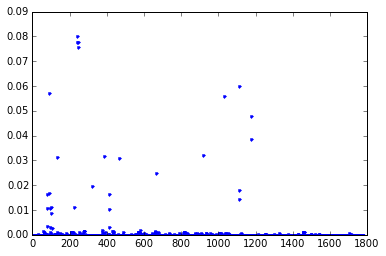

In [18]:
plt.plot(topics[:, 1]/sum(topics[:, 1]), '.')

In [19]:
help(model)

Help on LDAModel in module pyspark.mllib.clustering object:

class LDAModel(pyspark.mllib.common.JavaModelWrapper, pyspark.mllib.util.JavaSaveable, pyspark.mllib.util.Loader)
 |  A clustering model derived from the LDA method.
 |  
 |  Latent Dirichlet Allocation (LDA), a topic model designed for text documents.
 |  Terminology
 |  - "word" = "term": an element of the vocabulary
 |  - "token": instance of a term appearing in a document
 |  - "topic": multinomial distribution over words representing some concept
 |  References:
 |  - Original LDA paper (journal version):
 |  Blei, Ng, and Jordan.  "Latent Dirichlet Allocation."  JMLR, 2003.
 |  
 |  >>> from pyspark.mllib.linalg import Vectors
 |  >>> from numpy.testing import assert_almost_equal, assert_equal
 |  >>> data = [
 |  ...     [1, Vectors.dense([0.0, 1.0])],
 |  ...     [2, SparseVector(2, {0: 1.0})],
 |  ... ]
 |  >>> rdd =  sc.parallelize(data)
 |  >>> model = LDA.train(rdd, k=2, seed=1)
 |  >>> model.vocabSize()
 |  2
 | 

# Using ML Lib FP-Growth

In [13]:
from pyspark.mllib.fpm import FPGrowth
model = FPGrowth.train(transactions, minSupport=0.2, numPartitions=10)
result = model.freqItemsets().collect()

In [14]:

items = [frozenset(fi.items) for fi in result]
pruned_items = list(get_longest_sets_possible(items))
for item in pruned_items:
    print '|'.join([',' + str(i) + ',' for i in sorted(item, key=int)])

,-1,|,133,|,243,|,383,|,464,|,918,|,1033,|,1177,
,-1,|,89,|,242,|,244,|,918,|,1033,
,244,|,323,|,918,
,-1,|,89,|,133,|,243,|,244,|,383,|,918,
,-1,|,241,|,242,|,243,|,244,|,1033,|,1110,
,89,|,241,|,244,|,918,|,1110,
,-1,|,241,|,244,|,1033,|,1110,|,1177,
,-1,|,133,|,241,|,242,|,383,|,918,|,1177,
,-1,|,242,|,243,|,383,|,918,|,1177,
,-1,|,89,|,241,|,242,|,243,|,244,|,1033,
,-1,|,242,|,243,|,918,|,1178,
,-1,|,89,|,241,|,244,|,1033,|,1177,
,-1,|,89,|,241,|,242,|,243,|,244,|,1110,
,89,|,241,|,242,|,243,|,244,|,1033,|,1110,
,-1,|,241,|,323,|,918,
,-1,|,133,|,241,|,242,|,383,|,1177,|,1178,
,-1,|,242,|,323,|,918,
,-1,|,133,|,241,|,242,|,243,|,244,|,383,|,464,|,1033,|,1177,
,-1,|,918,|,1110,|,1177,
,89,|,242,|,244,|,918,|,1110,
,-1,|,133,|,241,|,243,|,383,|,918,|,1177,
,-1,|,133,|,242,|,243,|,383,|,464,|,1033,|,1178,
,241,|,243,|,323,|,918,
,-1,|,133,|,241,|,243,|,383,|,1177,|,1178,
,-1,|,242,|,243,|,244,|,1110,|,1177,|,1178,
,241,|,1112,
,-1,|,241,|,242,|,243,|,1033,|,1110,|,1177,
,-1,|,133,|,24